In [19]:
import matplotlib.pylab as plt
import numpy as np
plt.style.use("/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle")
%config InlineBackend.figure_format = 'svg'
import sys
import os
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")

option_calib = "_coti"
path_sav_fig = f"/afs/ihep.ac.cn/users/l/luoxj/PSD_LoweE/figure{option_calib}/"
if not os.path.isdir(path_sav_fig):
    os.mkdir(path_sav_fig)
with np.load(f"/afs/ihep.ac.cn/users/l/luoxj/PSD_LoweE/model{option_calib}/predict_combine.npz",
             allow_pickle=True) as f:
    dir_events_coti = f["dir_events"].item()
with np.load(f"/afs/ihep.ac.cn/users/l/luoxj/PSD_LoweE/model/predict_combine.npz",
             allow_pickle=True) as f:
    dir_events = f["dir_events"].item()
dir_diff_option_for_events = {"decon":dir_events, "coti":dir_events_coti}
print(dir_events["equen"])

[0.18386714 0.1927589  0.25088584 ... 0.41981177 0.26238203 1.49670336]


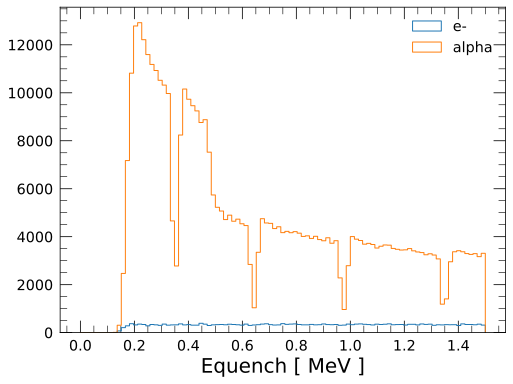

In [20]:
bins_equen= np.linspace(0,1.5,100)
plt.hist(dir_events["equen"][dir_events["tag"]==1],bins=bins_equen, histtype="step", label="e-")
plt.hist(dir_events["equen"][dir_events["tag"]==0],bins=bins_equen, histtype="step", label="alpha")
plt.xlabel("Equench [ MeV ]")
plt.legend()
plt.savefig(path_sav_fig+"ebnergy_spectrum.png")


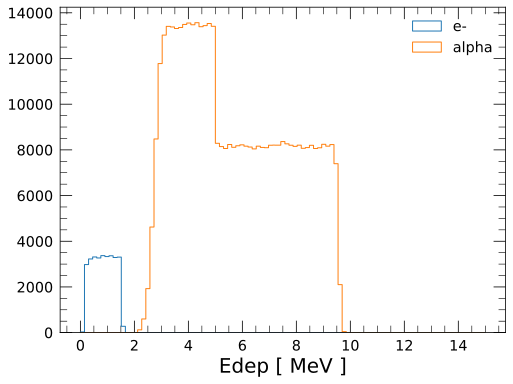

In [21]:
bins_edep= np.linspace(0,15,100)
plt.hist(dir_events["edep"][dir_events["tag"]==1],bins=bins_edep, histtype="step", label="e-")
plt.hist(dir_events["edep"][dir_events["tag"]==0],bins=bins_edep, histtype="step", label="alpha")
plt.xlabel("Edep [ MeV ]")
plt.legend()
plt.savefig(path_sav_fig+"energy_deposit_spectrum.png")

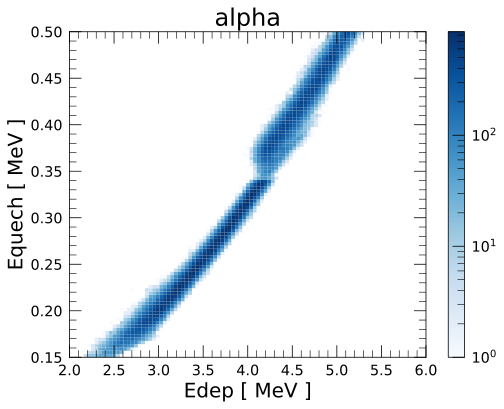

In [22]:
from matplotlib.colors import LogNorm
for tag in [0]:
    plt.figure()
    plt.hist2d(dir_events["edep"][dir_events["tag"]==tag],
           dir_events["equen"][dir_events["tag"]==tag], bins=(np.linspace(2,6,100),
                                                              np.linspace(0.15, 0.5,100)),
               cmap="Blues",norm=LogNorm())
    plt.xlabel("Edep [ MeV ]")
    plt.ylabel("Equech [ MeV ]")
    plt.colorbar()
    plt.title("alpha" if tag ==0 else "e-")

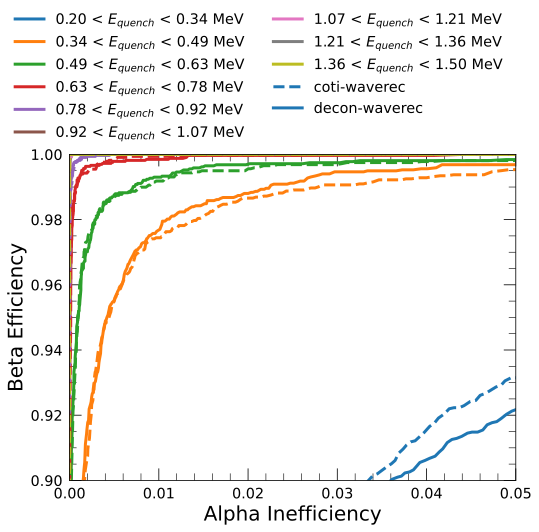

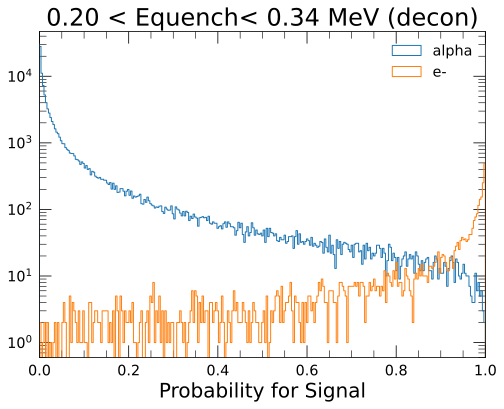

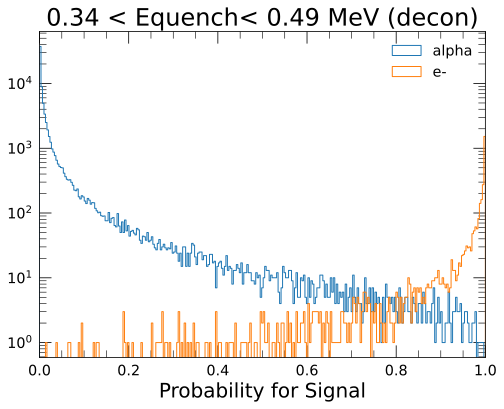

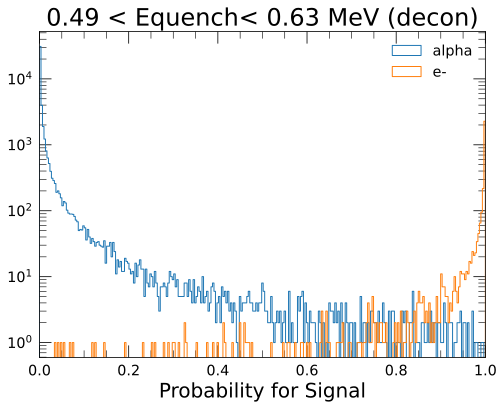

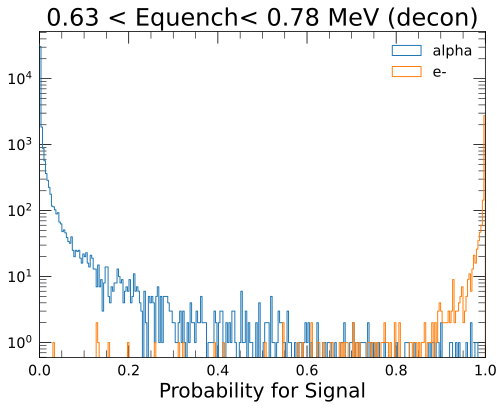

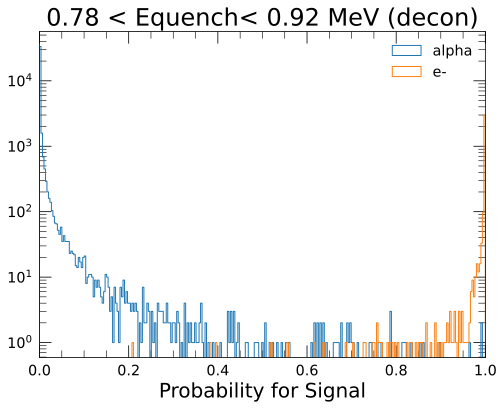

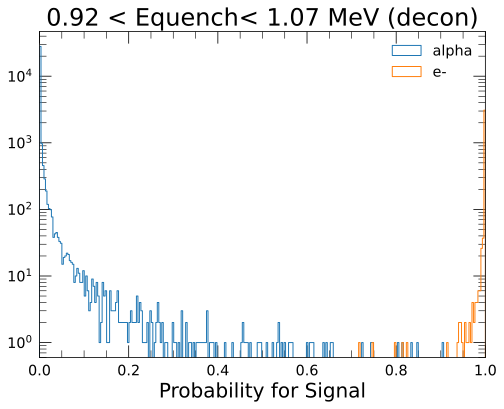

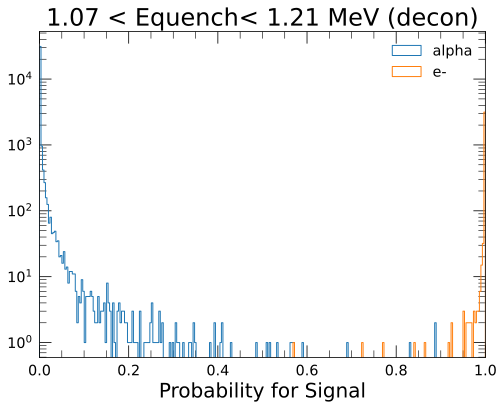

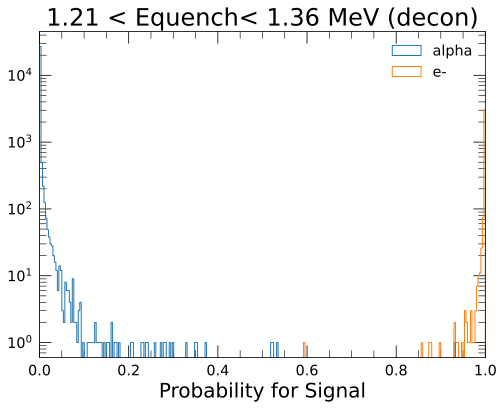

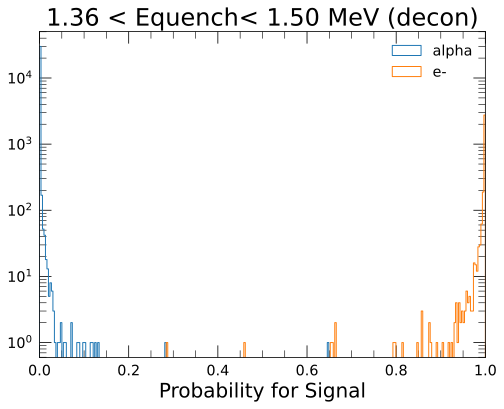

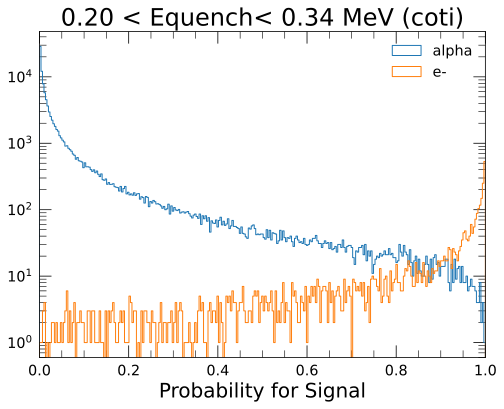

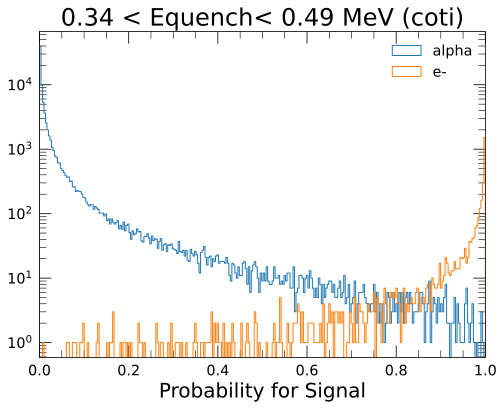

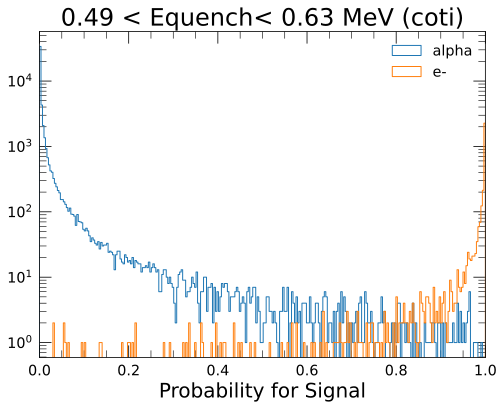

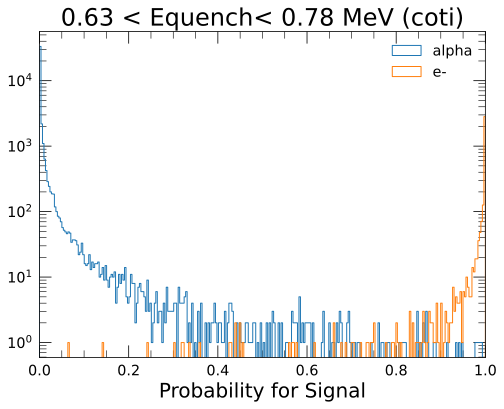

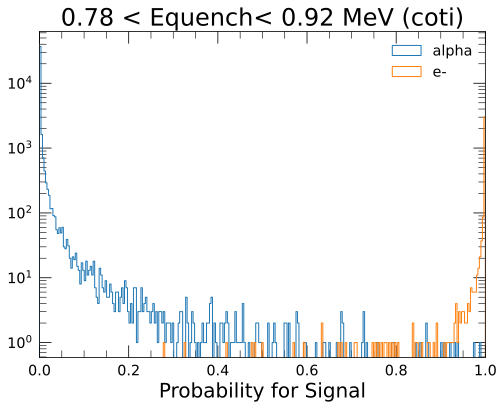

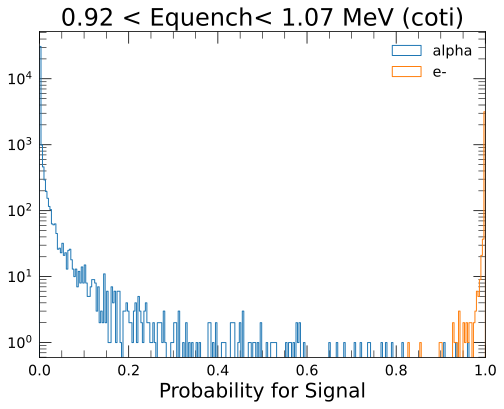

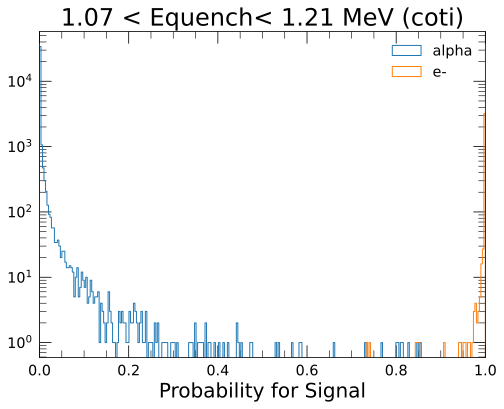

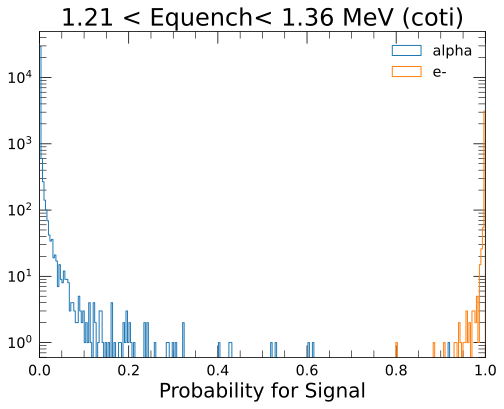

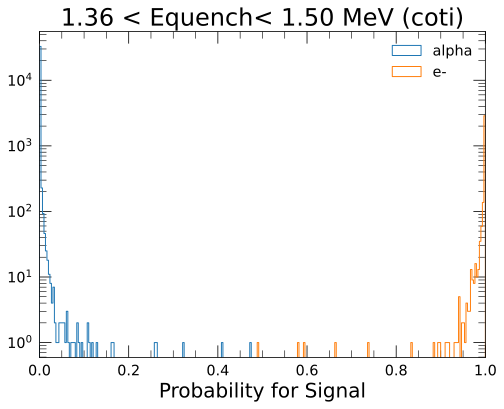

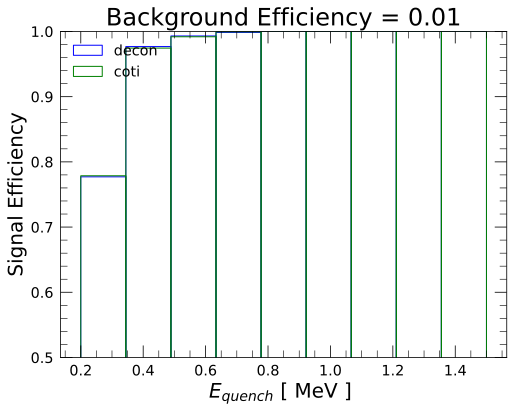

In [23]:
def GetBinCenter(edge):
    return (edge[:-1]+edge[1:])/2

def GetSigEff( v_eff_sig, v_eff_bkg, certain_eff_bkg=0.01):
    from scipy.interpolate import interp1d
    v_eff_bkg = np.array(v_eff_bkg)
    v_eff_sig = np.array(v_eff_sig)
    f = interp1d(v_eff_bkg[1:], v_eff_sig[1:], kind="linear")
    eff_sig_return = f(certain_eff_bkg)
    return (certain_eff_bkg, eff_sig_return)

def PlotPredictDistribution(dir_events_in_quench_bins:dict, title="", bins=np.linspace(0,1,300)):
    n0, bins0, patches0 = plt.hist(dir_events_in_quench_bins["PSD"][dir_events_in_quench_bins["tag"]==0], histtype="step",
             bins=bins, label="alpha")
    n1, bins1, patches1 = plt.hist(dir_events_in_quench_bins["PSD"][dir_events_in_quench_bins["tag"]==1], histtype="step",
             bins=bins, label="e-")
    plt.semilogy()
    plt.xlabel("Probability for Signal")
    plt.legend()
    plt.xlim(0,1)
    plt.title(title)
    return (n0,n1)

def GetSignalEfficiency(n0, n1,dir_events:dict,certain_eff_bkg:float,
                        label:str="", axes:plt.Axes=None,
                        ls=None,color=None, extra_label=""):
    # n0 = dir_events["PSD"][dir_events["tag"]==0]
    # n1 = dir_events["PSD"][dir_events["tag"]==1]
    eff_bkg = []
    eff_sig = []
    for i in range(len(n0)):
        eff_bkg.append(np.sum(n0[i:]) * 1.0 / np.sum(n0))
        eff_sig.append(np.sum(n1[i:]) * 1.0 / np.sum(n1))
    line = axes.plot(eff_bkg,eff_sig, label=label,
              ls=ls, color=color)
    if not extra_label=="":
        axes.plot(eff_bkg,eff_sig, label=extra_label,
                         ls=ls, color=line[0].get_color())

    (certain_eff_bkg, eff_sig_return) = GetSigEff(v_eff_bkg=eff_bkg, v_eff_sig=eff_sig,
                                                  certain_eff_bkg=certain_eff_bkg)
    return (eff_sig_return, line)

from PlotTools import GetListOfLineColor
import matplotlib.colors as colors
v_colors = list(colors._colors_full_map.values())
# Get signal efficiency about energy
certain_eff_bkg = 0.01
equen_bins = np.linspace(0.2, 1.5, 10)
fig,ax = plt.subplots(1,1)
dir_v_eff_sig = {}
v_lines = [] # save the line so we can get the color to draw another option_calib
for i_option, calib_option in enumerate(dir_diff_option_for_events.keys()):
    v_eff_sig = []
    for i_equen_bin in range(len(equen_bins)-1):
        if i_option>0:
            if i_equen_bin==0:
                label = "coti-waverec"
            else:
                label = None
            color = v_lines[i_equen_bin][0].get_color()
        else:
            label = f"{equen_bins[i_equen_bin]:.2f} < "+ "$E_{quench}$"+ f" < {equen_bins[i_equen_bin+1]:.2f} MeV"
            color = None
        plt.figure()
        dir_events_in_quench_bins = {}
        index_equen = (dir_diff_option_for_events[calib_option]["equen"]<equen_bins[i_equen_bin+1]) & (dir_diff_option_for_events[calib_option]["equen"]>equen_bins[i_equen_bin])
        for key in dir_diff_option_for_events[calib_option].keys():
            dir_events_in_quench_bins[key] = dir_diff_option_for_events[calib_option][key][index_equen]
        (n0, n1)=PlotPredictDistribution(dir_events_in_quench_bins,
                                title=f"{equen_bins[i_equen_bin]:.2f} < Equench< {equen_bins[i_equen_bin+1]:.2f} MeV ({calib_option})")
        eff_sig, line = GetSignalEfficiency(n0, n1,dir_events_in_quench_bins, certain_eff_bkg=certain_eff_bkg,
                                  label=label,
                                  axes=ax,color=color,
                                   ls="--" if calib_option=="coti" else "-",
                                            extra_label="")
        v_eff_sig.append(eff_sig)
        if i_option ==0:
            v_lines.append(line)
    dir_v_eff_sig[calib_option] = v_eff_sig

ax.plot([0,1],[0,0], color=v_lines[0][0].get_color(), label="decon-waverec")
ax.set_xlim(0,0.05)
ax.set_ylim(0.9,1)
ax.set_xlabel("Alpha Inefficiency")
ax.set_ylabel("Beta Efficiency")
ax.legend(bbox_to_anchor=(1.0, 1.0), ncol=2,loc="lower right")
# ax.legend()
ax.figure.savefig(path_sav_fig+"roc_curve_diff_quench.png",bbox_inches='tight')

plt.figure()
v_colors = GetListOfLineColor()
for i,calib_option in enumerate(dir_diff_option_for_events.keys()):
    plt.bar(GetBinCenter(equen_bins), dir_v_eff_sig[calib_option], width=np.diff(equen_bins), fill=False,
            edgecolor=v_colors[i], label=calib_option)
plt.legend()
plt.xlabel("$E_{quench}$ [ MeV ] ")
plt.ylabel("Signal Efficiency")
plt.title(f"Background Efficiency = {certain_eff_bkg}")
plt.ylim(0.5,1)
plt.savefig(path_sav_fig+"Signal_eff_diff_equen.png")

In [24]:
%precision 8
import pandas as pd
# from pd.table.plotting import table
# ax = plt.subplot(111,frameon=False)
v_label = []
v_keys = list(dir_v_eff_sig.keys())
for key in v_keys:
    if dir_v_eff_sig[key][-1]!=np.mean(dir_v_eff_sig[key]):
        dir_v_eff_sig[key].append(np.mean(dir_v_eff_sig[key]))
for i in range(len(equen_bins)-1):
    v_label.append(f"{equen_bins[i]:.2f} - {equen_bins[i+1]:.2f} MeV")
v_label.append("Mean")
# pd.set_option('precision', 3)
eff_sig_decon = np.array(dir_v_eff_sig[v_keys[0]],dtype="float64")*100
eff_sig_coti = np.array(dir_v_eff_sig[v_keys[1]],dtype="float64")*100
df = pd.DataFrame([eff_sig_decon,eff_sig_coti, 100*np.abs(eff_sig_coti-eff_sig_decon)/eff_sig_decon],
        columns=v_label, index=list(dir_v_eff_sig.keys())+["Relative Difference (%)"] )
# df.style.set_caption("Background Inefficiency")
# df.round(2)
df.T.columns.name = f'Bkg Inefficiency = {certain_eff_bkg*100}%'
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis
# pd.plotting.table(ax, df.T)
df.T

Bkg Inefficiency = 1.0%,decon,coti,Relative Difference (%)
0.20 - 0.34 MeV,77.706281,77.862591,0.201155
0.34 - 0.49 MeV,97.681617,97.442296,0.245001
0.49 - 0.63 MeV,99.300699,99.183161,0.118366
0.63 - 0.78 MeV,99.846767,99.939705,0.093080
0.78 - 0.92 MeV,100.000000,100.000000,0.000000
0.92 - 1.07 MeV,100.000000,100.000000,0.000000
1.07 - 1.21 MeV,100.000000,100.000000,0.000000
1.21 - 1.36 MeV,100.000000,100.000000,0.000000
1.36 - 1.50 MeV,100.000000,100.000000,0.000000
Mean,97.170596,97.158639,0.012305
